# Use of body navigation

In [2]:
%pylab inline

import os.path as op
import sys
# sys.path.append(op.expanduser("~/projects/pysegbase"))
# sys.path.append("/home/mjirik/projects/lisa")
sys.path.append(op.expanduser("~/projects/bodynavigation"))

import matplotlib.pyplot as plt
import numpy as np


import csv
import os

import copy
import glob
import io3d
import pandas as pd
import scipy
import scipy.signal
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.mixture

# tohle je tu ze zoufalství, správně by se mělo používat bodynavigation.bo
try:
    import bodynavigation.body_navigation
    reload(bodynavigation.body_navigation)

except:
    pass
import imtools
import sed3
from imtools import qmisc, misc, ml

# import lisa.body_navigation as bona
#from lisa import volumetry_evaluation
#import tiled_liver_statistics as lst

Populating the interactive namespace from numpy and matplotlib


/home/mjirik/miniconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
sliver_reference_dir = op.expanduser("~/data/medical/orig/sliver07/training/")
vs_mm_tmp = [1.5, 1.5, 1.5]

In [4]:
def read_data(orig_fname, ref_fname):
    # oname = orig_fnames[i]
    # rname = ref_fnames[i]
    data3d_orig, metadata = io3d.datareader.read(orig_fname)
    vs_mm1 = metadata['voxelsize_mm']
    data3d_seg, metadata = io3d.datareader.read(ref_fname)
    vs_mm = metadata['voxelsize_mm']
    
    return data3d_orig, data3d_seg, vs_mm

def sliver_reader(filename_end_mask="*[0-9].mhd", sliver_reference_dir="~/data/medical/orig/sliver07/training/", orig=True, seg=False):
    sliver_reference_dir = op.expanduser("~/data/medical/orig/sliver07/training/")
    orig_fnames = glob.glob(sliver_reference_dir + "*orig" +  filename_end_mask)
    ref_fnames = glob.glob(sliver_reference_dir + "*seg"+ filename_end_mask)

    orig_fnames.sort()
    ref_fnames.sort()
    output = []
    for i in range(0, len(orig_fnames)):
        oname = orig_fnames[i]
        rname = ref_fnames[i]
        orig_data, ref_data, vs_mm = read_data(oname, rname)
        import re
        numeric_label = re.search(".*g(\d+)", oname).group(1)
        out = (numeric_label, vs_mm, oname, orig_data, rname, ref_data)
        yield out

In [5]:
for one in sliver_reader("*[1].mhd"):
    print one[0]

001
011


# Batch segmentation of simple structures

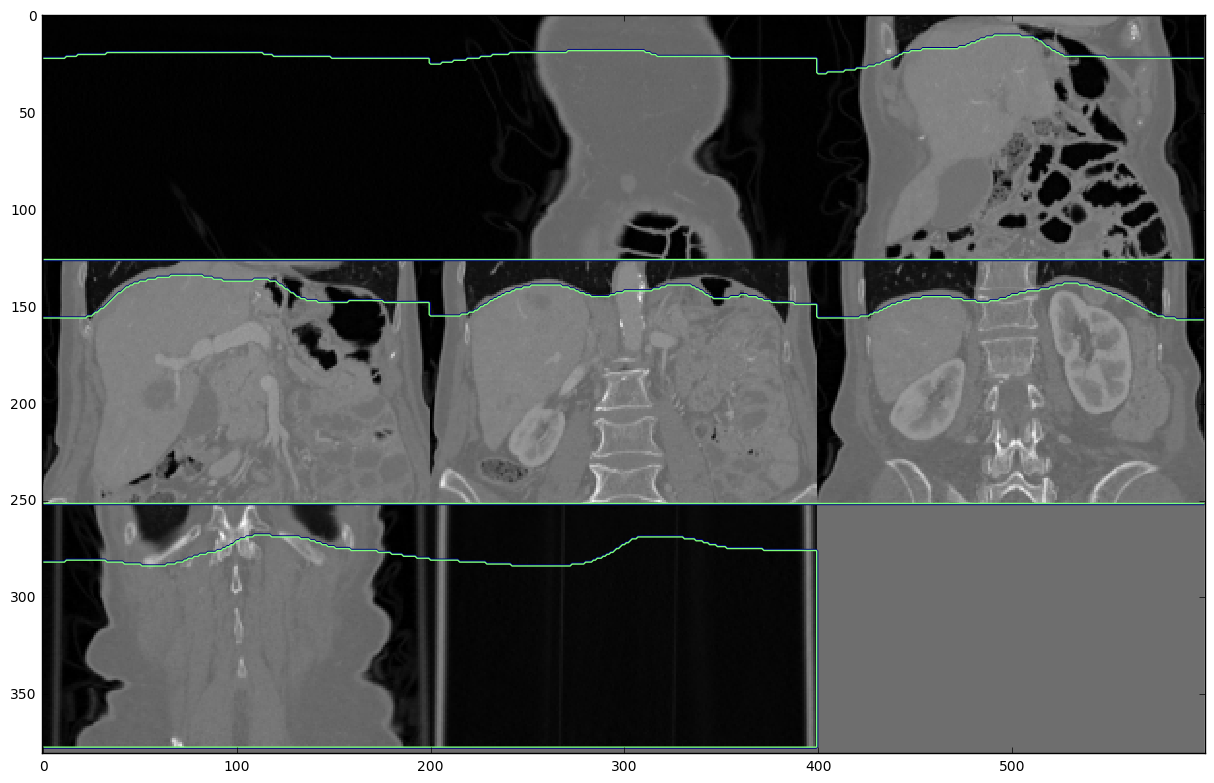

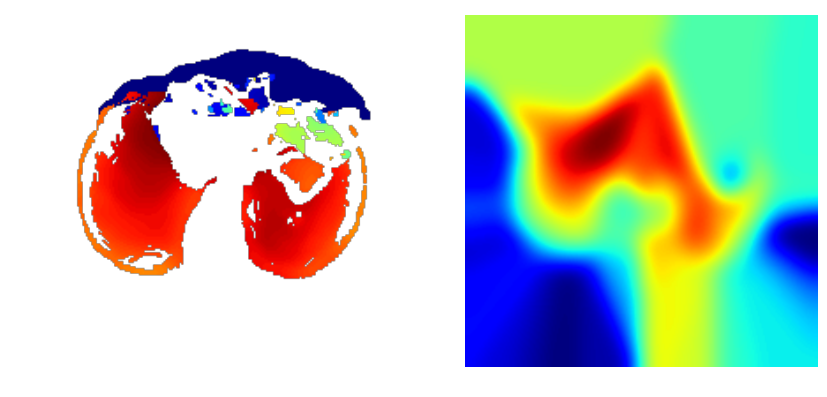

In [26]:
reload(bodynavigation.body_navigation)
# ktere soubory chci vybrat
pattern = '*01'
pattern = '*10'
for one in sliver_reader(pattern + ".mhd"):
    numeric_label, vs_mm, oname, orig_data, rname, ref_data = one

    data3dr_tmp = qmisc.resize_to_mm(orig_data, vs_mm, vs_mm_tmp)
    ss = bodynavigation.body_navigation.BodyNavigation(data3dr_tmp, vs_mm_tmp)
    seg = ss.get_diaphragm_mask().astype(np.uint8)
    # seg[ss.get_spine()] +=  6
    # seg[ss.get_lungs()] += 7
    #     seg = ss.get_lungs().astype(np.uint8)
    
    # data3d
    #     seg[:,:,int(spine_mean[2])] = 3
    #     seg[:,int(spine_mean[1])] = 3

    plt.figure(figsize = (15,15))
    sed3.show_slices(
        #    ss.get_diaphragm_mask(),
        data3dr_tmp,
        #ss.body[::15,:,:],
        #dst[::15,:,:],
        seg*2, 
#         first_slice_offset=32, 
        slice_step=25, axis=1, flipV=True)
    
    plt.figure(figsize=(10,10))
    plt.title(numeric_label)
    plt.subplot(121)
    plt.axis("off")
    profilet_empty, gr = ss.get_diaphragm_profile_image_with_empty_areas(return_gradient_image=True)
    plt.imshow(profilet_empty, cmap='jet')
    
    plt.subplot(122)
    profilet = ss.get_diaphragm_profile_image()
    plt.imshow(profilet, cmap='jet')
    plt.axis("off")

## Show detailed last case

In [8]:
print gr.shape
print ss.body.shape

(127, 200, 200)
(127, 200, 200)


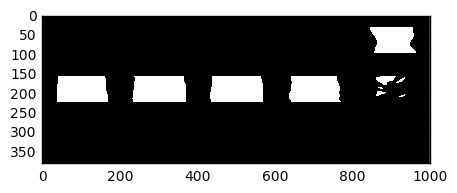

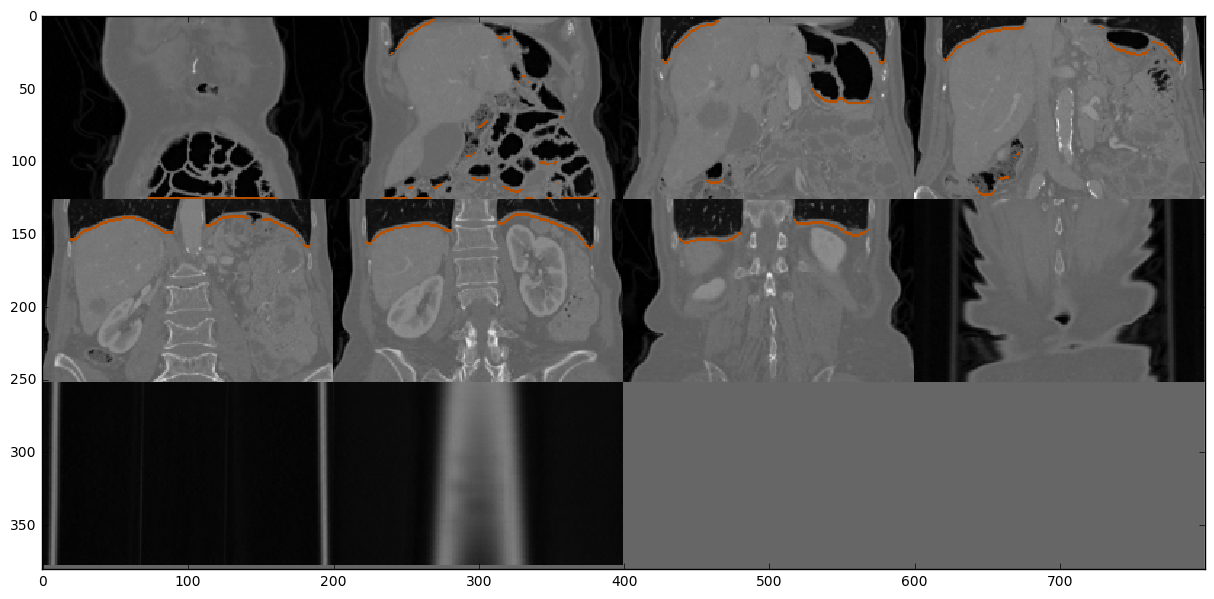

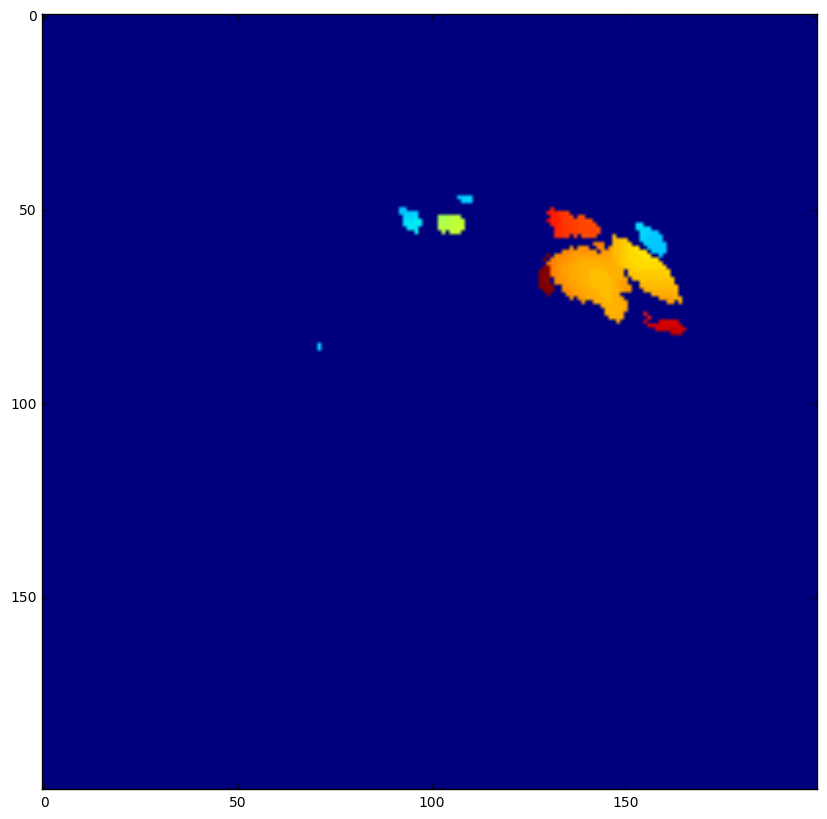

In [28]:
inner_body = scipy.ndimage.morphology.binary_erosion(ss.body, iterations=30)

plt.figure(figsize=(5,5))
sed3.show_slices(inner_body, slice_step=15, axis=1, flipV=True)

plt.figure(figsize=(15,15))
sed3.show_slices(ss.data3dr, seeds=gr > 8, 
                 
                 first_slice_offset=32, 
#                  slice_step=25, 
                 slice_step=18, 
                 axis=1, flipV=True)

plt.figure(figsize=(10,10))
img = ss.nonzero_projection(
    (gr * inner_body) > 10,
#     inner_body,# + gr>10, 
    axis=0)
# plt.plot(img)
# print img.shape
plt.imshow(img)

33726


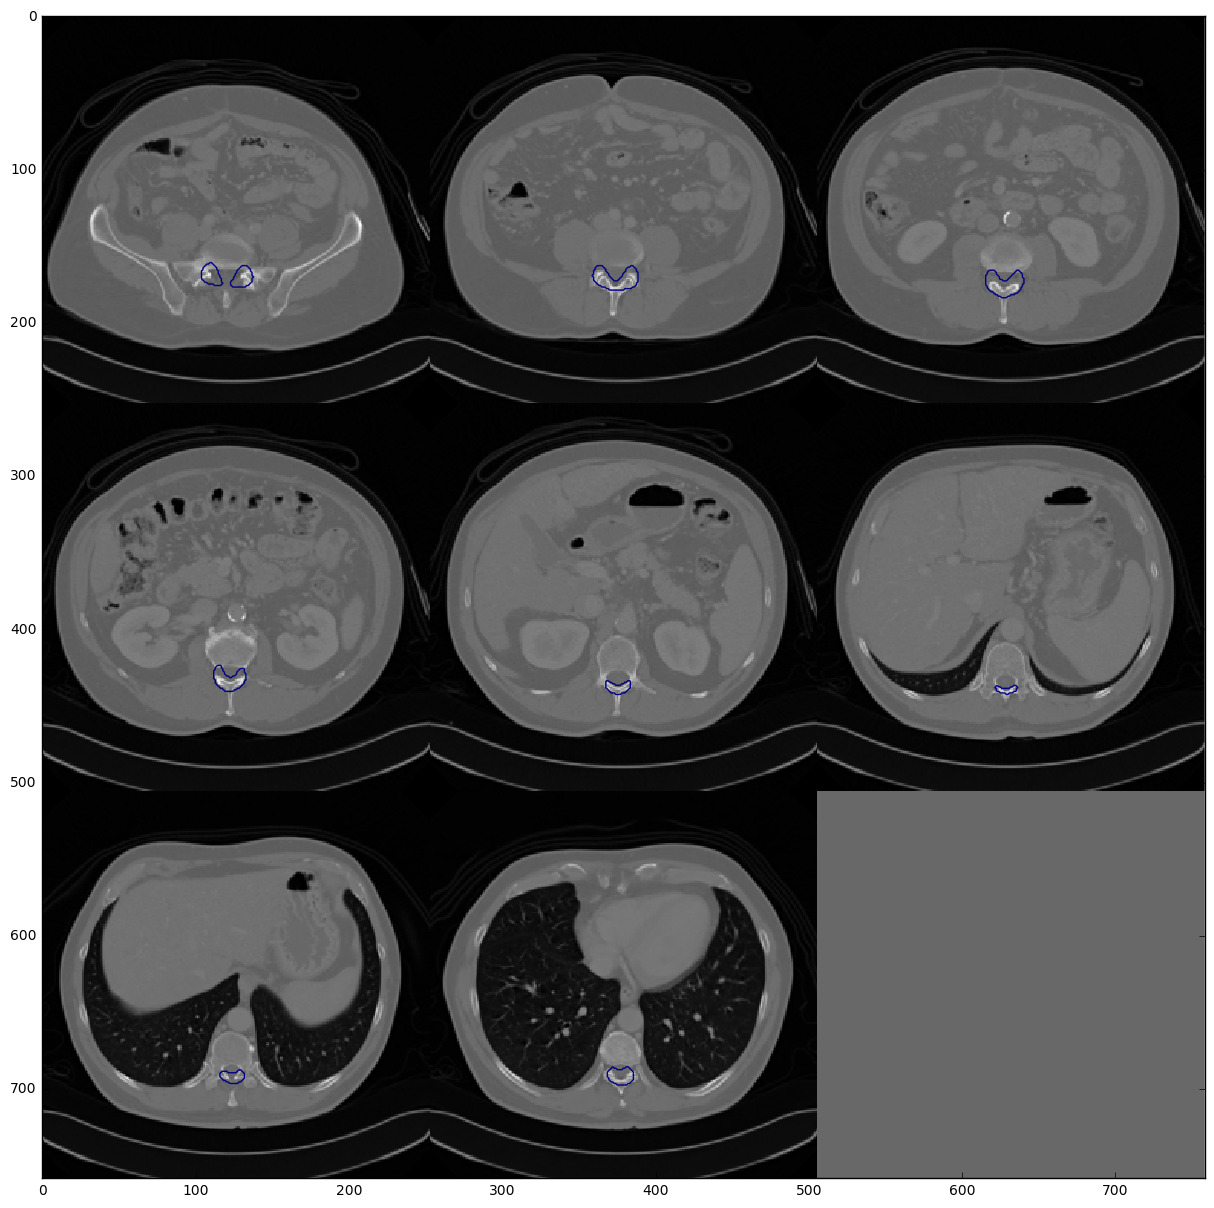

In [18]:
data3d_test, metadata = io3d.datareader.read(oname)
vs_mm_test = metadata['voxelsize_mm']
vs_mm_tmp = [1.5, 1.5, 1.5]
data3dr = qmisc.resize_to_mm(data3d_test, vs_mm_test, vs_mm_tmp)
spine = scipy.ndimage.filters.gaussian_filter(data3dr, sigma=[20, 5, 5]) > 200

print np.sum(spine)

plt.figure(figsize = (15,15))
sed3.show_slices(
#    ss.get_diaphragm_mask(),
    data3dr,
    #ss.body[::15,:,:],
    #dst[::15,:,:],
    spine, slice_step=25, axis=0)

# Natočení

<function rc at 0x7f8bdb158b18>
79


/home/mjirik/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


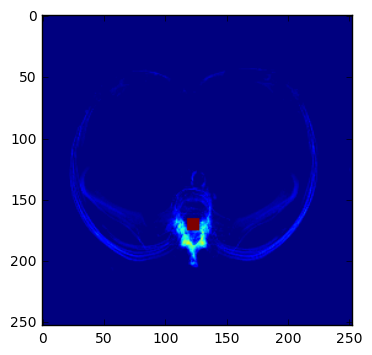

In [12]:
im = np.sum(data3dr > 430, axis=0)
plt.imshow(im)
ss.get_spine()
spine_center = ss.spine_center

maska = np.ones(im.shape)
maska[spine_center[1], spine_center[2]] = 0
dst = scipy.ndimage.morphology.distance_transform_edt(maska)
# im= dst*im
# plt.imshow(dst*im)

im2 = im.copy()
# rc = ribs_center.astype(int)
sc = spine_center[1:].astype(int)
print rc
# im2[rc[0]-5:rc[0]+5, rc[1]-5:rc[1]+5] = np.max(im)
im2[sc[0]-5:sc[0]+5, sc[1]-5:sc[1]+5] = np.max(im)*1.5
print np.max(im)
plt.imshow(im2)

im=im2

# Testování detekce symetrie

/home/mjirik/miniconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


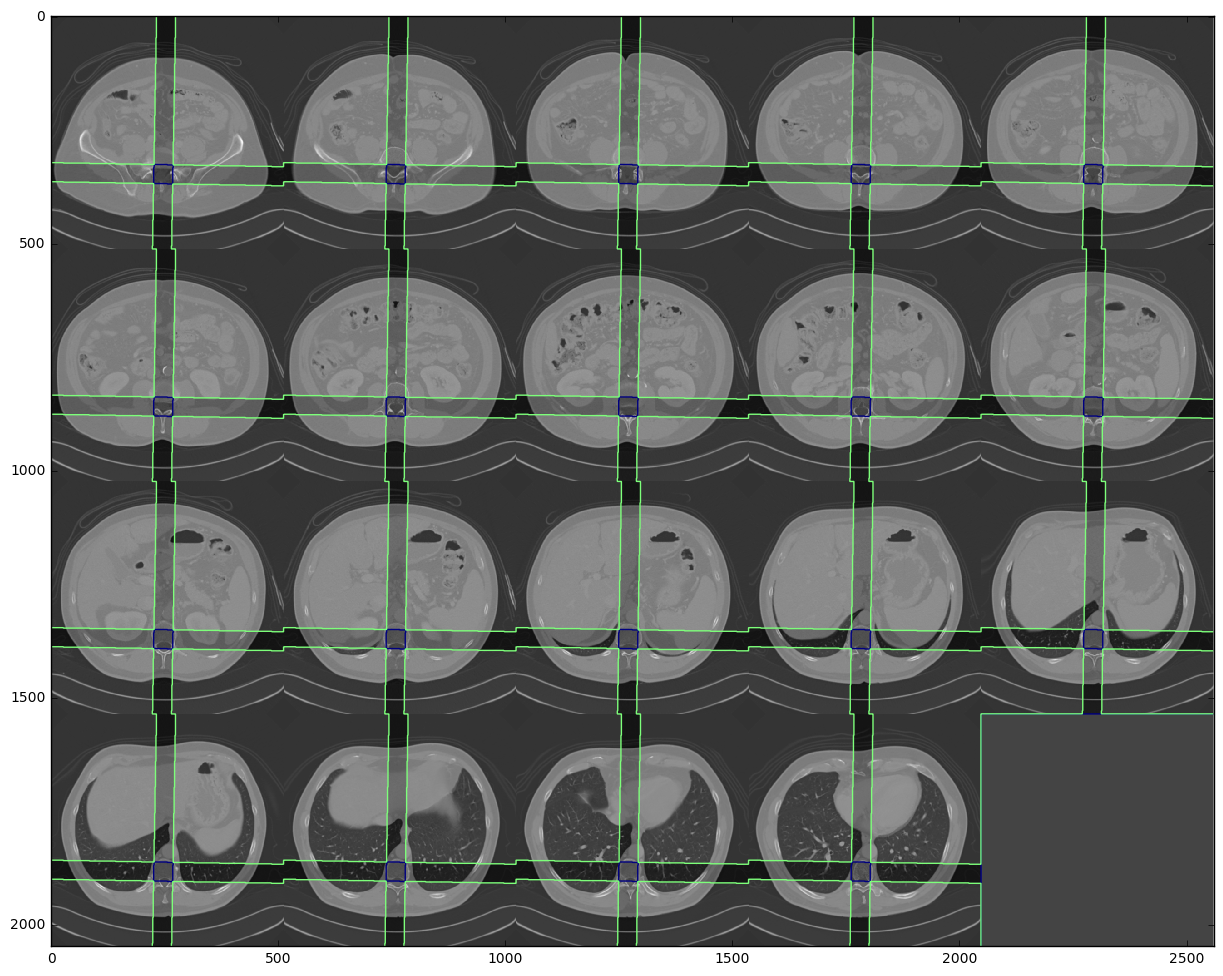

In [13]:
reload(bodynavigation.body_navigation)

sliver_reference_dir = op.expanduser("~/data/medical/orig/sliver07/training/")

orig_fnames = glob.glob(sliver_reference_dir + "*orig*[0].mhd")
ref_fnames = glob.glob(sliver_reference_dir + "*seg*[0].mhd")

orig_fnames.sort()
ref_fnames.sort()


for one in sliver_reader(pattern + ".mhd"):
    numeric_label, vs_mm, oname, orig_data, rname, ref_data = one

    # data3dr_tmp = qmisc.resize_to_mm(orig_data, vs_mm, vs_mm_tmp)
    ss = bodynavigation.body_navigation.BodyNavigation(orig_data, vs_mm)

    seg = (np.abs(ss.dist_coronal()) > 20).astype(np.uint8) + (np.abs(ss.dist_sagittal()) > 20).astype(np.uint8)

    # visualization
    plt.figure(figsize = (15,15))
    sed3.show_slices(
    #    ss.get_diaphragm_mask(),
#         data3dr_tmp + 400*seg.astype(int),
        orig_data + 400*seg.astype(int), 
        #ss.body[::15,:,:],
        #dst[::15,:,:],
        seg, slice_step=10, axis=0)

# Bránice

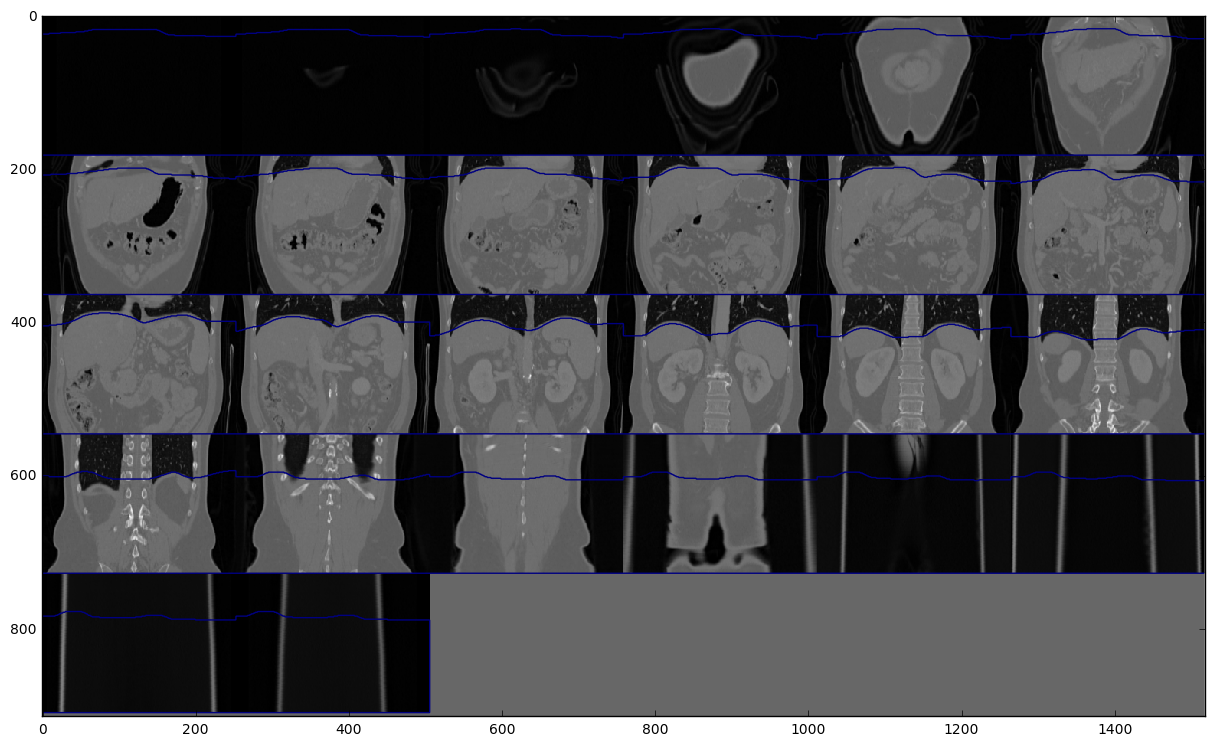

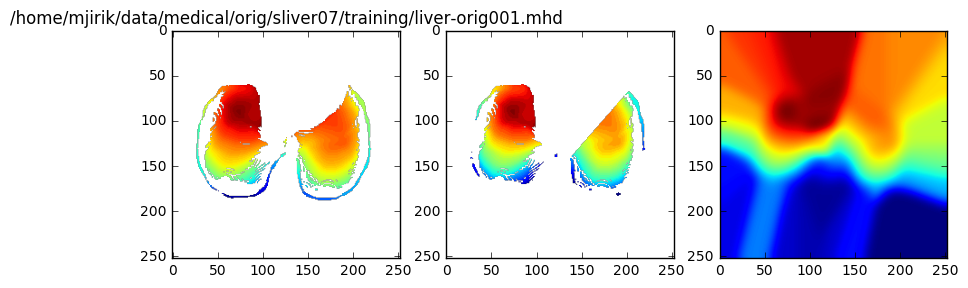

In [14]:
reload(bodynavigation.body_navigation)
reload(sed3)

sliver_reference_dir = op.expanduser("~/data/medical/orig/sliver07/training/")

orig_fnames = glob.glob(sliver_reference_dir + "*orig*[0-9].mhd")
ref_fnames = glob.glob(sliver_reference_dir + "*seg*[0-9].mhd")

orig_fnames.sort()
ref_fnames.sort()

for one in sliver_reader(pattern + ".mhd"):
    numeric_label, vs_mm, oname, orig_data, rname, ref_data = one

    data3dr_tmp = qmisc.resize_to_mm(orig_data, vs_mm, vs_mm_tmp)
    ss = bodynavigation.body_navigation.BodyNavigation(data3dr_tmp, vs_mm_tmp)
    seg = ss.get_diaphragm_mask().astype(np.uint8)

    
    plt.figure(figsize = (15,15))
    sed3.show_slices(
    #    ss.get_diaphragm_mask(),
        data3dr_tmp,
        #ss.body[::15,:,:],
        #dst[::15,:,:],
        seg, slice_step=10, axis=1,
        flipV=True,
        flipH=False
    )
    
#     plt.figure()
    plt.figure(figsize = (10,10))
    plt.subplot(131)
    plt.title(oname)
    profilet = ss.get_diaphragm_profile_image_with_empty_areas()
    profilet0 = profilet.copy()
    plt.imshow(profilet0, cmap='jet')
    plt.subplot(132)
    flat = ss.remove_pizza(profilet)
#     flat = ss._filter_diaphragm_profile_image_remove_outlayers(flat)
    flat = ss.filter_ignoring_nan(flat)
    plt.imshow(flat, cmap='jet')
    
    
    plt.subplot(133)
    profilet2 = ss.get_diaphragm_profile_image()
    plt.imshow(profilet2, cmap='jet')
    plt.show()
# print ld.shape, data3dr_test.shape

# plt.imshow(ld[5, :,:])
# plt.show()

### Outlayer detection

In [ ]:
plt.imshow(flat)

select = 1-np.isnan(flat)
x,y = np.nonzero(select)
z = flat[select==True]

print len(x), np.prod(flat.shape), z.shape

In [15]:
flat0 = flat.copy()
flat0[np.isnan(flat)] = 0
x,y = np.nonzero(flat0)
# print np.prod(flat.shape)
# print len(y)

z = flat[(x,y)]

data = np.asarray([x,y,z]).T

data
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope(contamination=.1)
clf.fit(data)
y_pred = clf.decision_function(data)

np.sum(y_pred > 0)

out_inds = y_pred < 0
flat[(x[out_inds], y[out_inds])] = np.NaN

In [ ]:
plt.imshow(flat)

# Adaptivní segmentace žeber

hledá se největší spád intenzit pod povrchem kůže

In [ ]:
sliver_reference_dir = op.expanduser("~/data/medical/orig/sliver07/training/")

orig_fnames = glob.glob(sliver_reference_dir + "*orig*[1-4].mhd")
ref_fnames = glob.glob(sliver_reference_dir + "*seg*[1-4].mhd")

orig_fnames.sort()
ref_fnames.sort()

In [ ]:
additional_robust_density = 30
gr2_threshold = 30
distance_from_surface_mm = 30
relative_distance_from_surface = 0.2
density_threshold_low = 100
density_threshold_high = 500
sigma = 1
vs_mm0 = 1.5
vs_mm_tmp = [vs_mm0, vs_mm0, vs_mm0]

In [ ]:
import bodynavigation.body_navigation as bona

In [ ]:
pattern = "*[11]"
for one in sliver_reader(pattern + ".mhd"):
    numeric_label, vs_mm, oname, orig_data, rname, ref_data = one

    data3dr_tmp = qmisc.resize_to_mm(orig_data, vs_mm, vs_mm_tmp)
    data3dr_tmp = scipy.ndimage.filters.gaussian_filter(data3dr_tmp, sigma=sigma)

    ss = bona.BodyNavigation(data3dr_tmp, vs_mm_tmp)
    surf_dist = ss.dist_to_surface()
    max_dist = np.max(surf_dist)
    print "max depth", np.max(surf_dist)

    #location_filter = (surf_dist > 0) & (surf_dist < distance_from_surface_mm / vs_mm0)
    location_filter = (surf_dist > 0) & (surf_dist < (max_dist * relative_distance_from_surface))
    intensity_filter = (data3dr_tmp > density_threshold_low) & (data3dr_tmp < density_threshold_high)

    plt.figure()
    hist = plt.hist(data3dr_tmp[location_filter & intensity_filter].ravel(), 100)



    filtered_hist = scipy.ndimage.filters.gaussian_filter(hist[0], sigma=5)
    try:
        gr1 = np.gradient(filtered_hist)
        gr2 = np.gradient(np.gradient(filtered_hist))

        # hledáme pomocí prahu druhé derivace
#         inds = find(gr2 > gr2_threshold)
#         ribs_thr = hist[1][inds[-1]] + additional_robust_density

#         extrem = scipy.signal.argrelextrema(gr2, np.greater)
        extrem = scipy.signal.argrelextrema(gr1, np.less)
        print "extr ", extrem[0][0]
        ribs_thr = hist[1][round(extrem[0][0])] + additional_robust_density
        
        print np.max(gr2), np.min(gr2)
        
        ribs = location_filter & (data3dr_tmp > ribs_thr)

        print hist[1][extrem]
    except:
#         import ipdb
#         ipdb.set_trace()
        print "vyjimka ", i
        import traceback
        traceback.print_exc()
        print traceback.format_exc()
        
    plt.figure()
    plt.plot(
        hist[1][1:], hist[0] * 0.1,
        hist[1][1:], filtered_hist * 0.1,
        hist[1][1:], gr1,
        hist[1][1:], gr2 * 5,
    )
    plt.legend(['histogram', 'filtered', '1st derivative', '2nd derivative'])
#     plt.yticks([])
    try:
        plt.axvline(ribs_thr, color='k', linestyle='--')
        plt.axvline(ribs_thr - additional_robust_density, color='k', linestyle=':')
#         plt.axhline(gr2_threshold*5, color='k', linestyle='--')

        plt.figure(figsize = (15,15))
        sed3.show_slices(
        #    ss.get_diaphragm_mask(),
            data3dr_tmp,
        #     ss.get_body(),
        #     ss.dist_to_surface(),
        #     location_filter.astype(np.int8) + 
            ribs.astype(np.int8)+location_filter.astype(np.int8),
            #ss.body[::15,:,:],
            #dst[::15,:,:],
        #     seg, 
            slice_step=10, axis=1,
            flipV=True,
            flipH=False
        ) 
    except:
        import traceback
        traceback.print_exc()
        print traceback.format_exc()